In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
import rembg

In [19]:
df = pd.read_csv('dataset.csv')
df.head(10)

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART
5,Image_6.jpg,CAIRNS BIRDWING
6,Image_7.jpg,GREEN CELLED CATTLEHEART
7,Image_8.jpg,EASTERN DAPPLE WHITE
8,Image_9.jpg,BROWN SIPROETA
9,Image_10.jpg,RED POSTMAN


In [21]:
CLASSES_COUNT = 7
classes_list = df['label'].value_counts()[:CLASSES_COUNT].index.tolist()
classes_list

['MOURNING CLOAK',
 'SLEEPY ORANGE',
 'ATALA',
 'BROWN SIPROETA',
 'CRECENT',
 'SCARCE SWALLOW',
 'BANDED ORANGE HELICONIAN']

In [22]:
df = df[df['label'].isin(classes_list)]
len(df)

728

In [23]:
df['label'].nunique()

7

In [24]:
samples_cnt_by_label = df['label'].value_counts()
samples_cnt_by_label

label
MOURNING CLOAK              131
SLEEPY ORANGE               107
ATALA                       100
BROWN SIPROETA               99
SCARCE SWALLOW               97
CRECENT                      97
BANDED ORANGE HELICONIAN     97
Name: count, dtype: int64

<Axes: title={'center': 'Samples distribution by label'}, xlabel='label'>

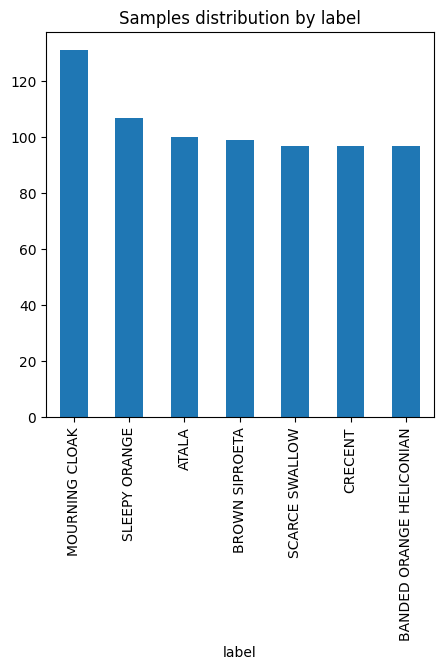

In [28]:
samples_cnt_by_label.plot.bar(x='label', y='count', figsize=(5, 5), title='Samples distribution by label')

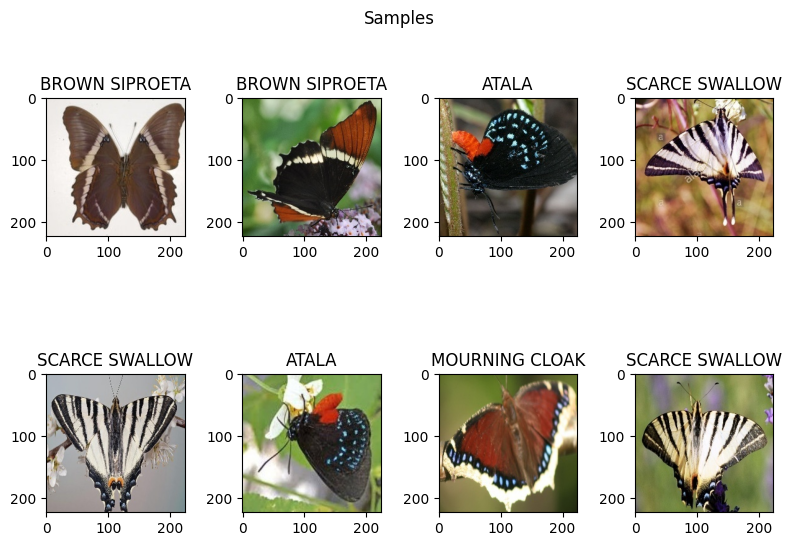

In [31]:
samples_rows_cnt = 2
samples_cols_cnt = 4
samples_examples_df = df.sample(frac=1).groupby('label').head(samples_rows_cnt * samples_cols_cnt)

fig, ax = plt.subplots(samples_rows_cnt, samples_cols_cnt, figsize=(8, 6))
fig.suptitle('Samples')
fig.tight_layout()

for i in range(samples_rows_cnt):
    for j in range(samples_cols_cnt):
        img_df_row = df.iloc[i * samples_cols_cnt + j]
        img = cv2.imread(os.path.join('.', 'images', img_df_row['filename']))
        img_to_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img_to_show)
        ax[i, j].set_title(img_df_row['label'])

In [32]:
NEW_IMAGE_SIZE = (64, 64)

def remove_background(image, size=NEW_IMAGE_SIZE):
    resized_image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
    return rembg.remove(resized_image)

def save_preprocessed_images(df, path=os.path.join('.', 'preprocessed_images'), verbose=True):
    if not os.path.exists(path):
        os.makedirs(path)

    for i in range(len(df)):
        df_row = df.iloc[i]
        src_image = cv2.imread(os.path.join('.', 'images', df_row['filename']))
        preprocessed_image = remove_background(src_image)
        cv2.imwrite(os.path.join(path, df_row['filename']), preprocessed_image)

        if verbose:
            print("[INFO] Processed: {}/{}".format(i, len(df)))

# save_preprocessed_images(df) uncomment if you want to save preprocessed images

[INFO] Processed: 0/728
[INFO] Processed: 1/728
[INFO] Processed: 2/728
[INFO] Processed: 3/728
[INFO] Processed: 4/728
[INFO] Processed: 5/728
[INFO] Processed: 6/728
[INFO] Processed: 7/728
[INFO] Processed: 8/728
[INFO] Processed: 9/728
[INFO] Processed: 10/728
[INFO] Processed: 11/728
[INFO] Processed: 12/728
[INFO] Processed: 13/728
[INFO] Processed: 14/728
[INFO] Processed: 15/728
[INFO] Processed: 16/728
[INFO] Processed: 17/728
[INFO] Processed: 18/728
[INFO] Processed: 19/728
[INFO] Processed: 20/728
[INFO] Processed: 21/728
[INFO] Processed: 22/728
[INFO] Processed: 23/728
[INFO] Processed: 24/728
[INFO] Processed: 25/728
[INFO] Processed: 26/728
[INFO] Processed: 27/728
[INFO] Processed: 28/728
[INFO] Processed: 29/728
[INFO] Processed: 30/728
[INFO] Processed: 31/728
[INFO] Processed: 32/728
[INFO] Processed: 33/728
[INFO] Processed: 34/728
[INFO] Processed: 35/728
[INFO] Processed: 36/728
[INFO] Processed: 37/728
[INFO] Processed: 38/728
[INFO] Processed: 39/728
[INFO] Pro

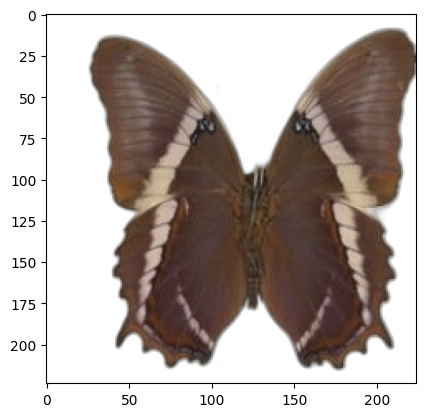

In [38]:
show_rembg_result_sample = df.iloc[0]['filename']
show_rembg_result_sample_image = cv2.imread(os.path.join('.', 'images', show_rembg_result_sample))
plt.imshow(rembg.remove(cv2.cvtColor(show_rembg_result_sample_image, cv2.COLOR_BGR2RGB)))

In [39]:
def load_preprocessed_images(df, folder_path=os.path.join('.', 'preprocessed_images')):
    images = []
    flatten_images = []
    labels = []

    for i in range(len(df)):
        df_row = df.iloc[i]
        src_image = cv2.imread(os.path.join(folder_path, df_row['filename']))
        images.append(cv2.cvtColor(src_image, cv2.COLOR_BGR2GRAY))
        flatten_images.append(src_image.flatten())
        labels.append(df_row['label'])

    return np.array(images), np.array(flatten_images), np.array(labels)

images, flatten_images, labels = load_preprocessed_images(df)

print("[INFO] Features matrix: {:.2f} MB".format(flatten_images.nbytes / (1024 * 1000.0)))
print("[INFO] Flatten image shape: {}".format(flatten_images[0].shape))

[INFO] Features matrix: 8.74 MB
[INFO] Flatten image shape: (12288,)


In [73]:
X = flatten_images
Y = labels

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
print(f'X_train.shape = {X_train.shape}')

X_train.shape = (582, 12288)


In [68]:
k = np.arange(1, 70)
params = {
    'n_neighbors': k,
    'weights': ['uniform', 'distance']
}
model=KNeighborsClassifier()
model_grid = GridSearchCV(model, params, verbose=4)
model_grid.fit(X, Y)
model_grid

Fitting 5 folds for each of 138 candidates, totalling 690 fits
[CV 1/5] END ....n_neighbors=1, weights=uniform;, score=0.562 total time=   0.0s
[CV 2/5] END ....n_neighbors=1, weights=uniform;, score=0.541 total time=   0.0s
[CV 3/5] END ....n_neighbors=1, weights=uniform;, score=0.555 total time=   0.0s
[CV 4/5] END ....n_neighbors=1, weights=uniform;, score=0.600 total time=   0.0s
[CV 5/5] END ....n_neighbors=1, weights=uniform;, score=0.600 total time=   0.0s
[CV 1/5] END ...n_neighbors=1, weights=distance;, score=0.562 total time=   0.0s
[CV 2/5] END ...n_neighbors=1, weights=distance;, score=0.541 total time=   0.0s
[CV 3/5] END ...n_neighbors=1, weights=distance;, score=0.555 total time=   0.0s
[CV 4/5] END ...n_neighbors=1, weights=distance;, score=0.600 total time=   0.0s
[CV 5/5] END ...n_neighbors=1, weights=distance;, score=0.600 total time=   0.0s
[CV 1/5] END ....n_neighbors=2, weights=uniform;, score=0.637 total time=   0.0s
[CV 2/5] END ....n_neighbors=2, weights=unifor

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69]),
                         'weights': ['uniform', 'distance']},
             verbose=4)

In [64]:
model_grid.best_params_

{'n_neighbors': 3, 'weights': 'uniform'}

In [69]:
model = KNeighborsClassifier(n_neighbors=3, weights='uniform')
model.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=3)

In [70]:
Y_pred = model.predict(X_test)
acc = model.score(X_test, Y_test)
acc

0.6712328767123288

<Axes: >

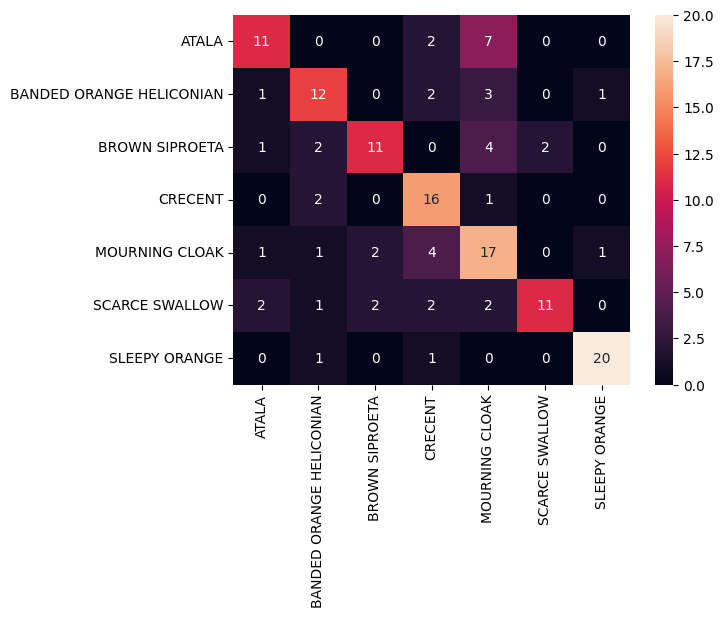

In [108]:
sns.heatmap(confusion_matrix(Y_test, Y_pred), xticklabels=model.classes_, yticklabels=model.classes_, annot=True)

In [72]:
print(classification_report(Y_test, Y_pred))

                          precision    recall  f1-score   support

                   ATALA       0.69      0.55      0.61        20
BANDED ORANGE HELICONIAN       0.63      0.63      0.63        19
          BROWN SIPROETA       0.73      0.55      0.63        20
                 CRECENT       0.59      0.84      0.70        19
          MOURNING CLOAK       0.50      0.65      0.57        26
          SCARCE SWALLOW       0.85      0.55      0.67        20
           SLEEPY ORANGE       0.91      0.91      0.91        22

                accuracy                           0.67       146
               macro avg       0.70      0.67      0.67       146
            weighted avg       0.70      0.67      0.67       146



In [80]:
skf = StratifiedKFold()
stats = []

for train_index, test_index in skf.split(X, Y):
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    Y_train_cv, Y_test_cv = Y[train_index], Y[test_index]

    model.fit(X_train_cv, Y_train_cv)

    Y_pred_cv = model.predict(X_test_cv)
    results = {
        'accurracy': accuracy_score(Y_test_cv, Y_pred_cv),
        'precision': precision_score(Y_test_cv, Y_pred_cv, average='weighted'),
        'recall': recall_score(Y_test_cv, Y_pred_cv, average='weighted'),
        'f1': f1_score(Y_test_cv, Y_pred_cv, average='weighted'),
    }

    stats.append(results)

print('Cross-validation results:')
print(stats)

Cross-validation results:
[{'accurracy': 0.6027397260273972, 'precision': 0.6233170279281686, 'recall': 0.6027397260273972, 'f1': 0.5923786728419952}, {'accurracy': 0.5342465753424658, 'precision': 0.5426092371000054, 'recall': 0.5342465753424658, 'f1': 0.5237203855969209}, {'accurracy': 0.6027397260273972, 'precision': 0.6465411492327209, 'recall': 0.6027397260273972, 'f1': 0.6060998874809458}, {'accurracy': 0.6344827586206897, 'precision': 0.6776645010827919, 'recall': 0.6344827586206897, 'f1': 0.6367734283202345}, {'accurracy': 0.6413793103448275, 'precision': 0.6943556457065585, 'recall': 0.6413793103448275, 'f1': 0.6390754172962376}]
